In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import json

from classes.experiment import Experiment
from classes.agent import Agent

from methods.states_params_importer import import_states_params_asdict
from methods.action_plans import fetch_action_plan, generate_action_plan

%matplotlib inline

In [2]:
## Import behavioural experiment
with open('/mnt/c/Users/vbtes/CompProjects/vbtCogSci/csl_global_analysis/data/global_modelling_data.obj', 'rb') as inFile:
    modelling_data = pickle.load(inFile)

print(len(modelling_data.keys()))

models_dict = import_states_params_asdict()


420


In [3]:
models_dict['actions']['tree_search_hard_horizon']['params']['args']

['obs',
 0.1,
 array([-100,  -75,  -50,  -25,    0,   25,   50,   75,  100]),
 1,
 (<function methods.policies.epsilon_greedy_init.<locals>.e_greedy_policy(action_values)>,
  <function methods.policies.epsilon_greedy_init.<locals>.pmf_e_greedy_policy(action_taken, action_values)>,
  <function methods.policies.epsilon_greedy_init.<locals>.params_e_greedy_policy(action_values)>),
 5,
 'posterior_unweighted',
 'expected_information_gained',
 1]

In [4]:
"""
Key parameters
"""

"""
Specifies whether loaded data will be used or not
fit_or_run == True: use loaded data

if true, it will treat all states as realised and will provide the posterior judgment and parameters of the specified agent

More granular options exist below to use parts of the existing data, e.g. actions, but let the rest be generated online
"""
fit_or_run = False # If false, no data will be used 

""" 
Modifies default parameters:

External states
Strength/rigidity - default is 0.5
"""

rigidity = 0.5
#models_dict['external']['OU_Network']['params']['args'][0] = rigidity
#models_dict['internal']['normative']['params']['args'][-2] = rigidity
#models_dict['internal']['normative']['params']['args'][0] = rigidity

""" 
Variance/noise - default is 3
"""
sigma = 3
models_dict['external']['OU_Network']['params']['args'][2] = sigma
#models_dict['internal']['normative']['params']['args'][-1] = 15*sigma
#models_dict['internal']['LC_discrete_att']['params']['args'][-2] = 6*sigma

""" 
Actives states

Hard horizon tree search
Horizon (tree depth):
"""
#models_dict['actions']['tree_search_hard_horizon']['params']['args'][-1] = 2

""" 
Utility function
information gained or resource rational
"""
#models_dict['actions']['tree_search_hard_horizon']['params']['args'][-2] = 'resource_rational'#'expected_information_gained'
#models_dict['actions']['tree_search_hard_horizon']['params']['kwargs']['resource_rational_parameter'] = 1

' \nUtility function\ninformation gained or resource rational\n'

In [5]:

""" 
Loads data using the part_key variable which links to behavioural data
"""

part_key = '5fb91837b8c8756d924f7351'
conditions = ['generic_0', 'congruent', 'incongruent', 'implausible']
cond = conditions[1]

part_data = modelling_data[part_key]
part_experiment = part_data['experiment']
trials = part_data['trials']

trial_data = trials[cond]
## Data from trial
model_name = trial_data['name'][:-2]
difficulty = cond
data = trial_data['data'] # Raw numerical data of variable values
ground_truth = trial_data['ground_truth'] # Ground truth model from which data has been generated
ground_truth = np.array([-1, 0, 0, -1, 0, 0])
ground_truth = np.array([-1, 0, 0, 0, -1, 0])
ground_truth = np.array([0, 0, -1, 0, 0, -1])

# Unpack generic trial relevant parameters
N = data.shape[0] - 0 # Number of datapoints
N = 150
K = data.shape[1] # Number of variable

inters = trial_data['inters'] # Interventions as is
inters_fit = trial_data['inters_fit'] # Interventions with removed movements
judgement_data = trial_data['links_hist'] # Change in judgement sliders
posterior_judgement = trial_data['posterior'] # Final states of judgement sliders
prior_judgement = trial_data['prior'] if 'prior' in trial_data.keys() else None
utid = trial_data['utid']

In [6]:
"""
Set up agent states and fitting options
"""

"""
Choose whether to use fitted parameters or default ones
"""
use_fitted_parameters = False


"""
Construct agents by choosing its states

1. Internal states
2. Sensory states
3. Active states
"""

internal_states_list = [
    #'normative_&_1',
    #'LC_discrete_&_1',
    #'LC_discrete_att_&_att',
    #'change_obs_fk_&_att_cha',
    'mean_field_vis'
]
sensory_states_list = [
    'omniscient'
]
action_states_list = [
    #'experience_vao',
    #'tree_search_soft_horizon',
    'tree_search_hard_horizon'
]

"""
Choose the agent's behaviour

behaviour specifies how the agent acts: 
    - actor (str): acts according to the action state 
    - random (str): random actions
    - obs (str): only observes, takes no actions (useful for generating sample paths without inference)

use_action_plan specifies a predefined action set and will override the behaviour variable if not set to None
Action plans can be added by amended in the ./methods/action_plan.py file, current ones include:
    - None (bool): default, the agent will behave according to the behaviour variable
    - data (str): will make an action plan out of the preloaded data if available (participant or saved model data)  
    - [0, 1] (float): will generate an action plan where the agent intervenes the proportion of time given by the argument with swipes from 90 to -90
    - mid_single_swipe__90__1/3 (str): will perform a single swipe at 90 on one variable for 1/3 of the time in the middle of a trial
    - double_swipe__90__1/6: single swipe at 1/3 and another at 2/3
    - bespoke (str): see options in the action_plans.py file in the fetch_action_plan function, add an elif statement with the name of the action plan and its specification to add new options
"""
behaviour = 'actor' # Can be random, obs, or actor
use_action_plan = None


"""
Detailed online report of agents beliefs
(No impact on behaviour)
"""
verbose = True

"""
Options for data generation and bespoke sample paths

Use this options for simulating data but are not interested in the inference process
Set bespoke_experiment to False for standard paths with inference
"""
bespoke_experiment = False

if bespoke_experiment:
    ground_truth = np.array([1, 0, 0, 1, 0, 0])
    #ground_truth = np.array([1, 1, 0, 1, 0, 0])
    #ground_truth = np.array([1, -1, 0, 1, 0, 0])

    N = data.shape[0] - 0 # Number of datapoints
    N = 100

    internal_states_list = ['LC_discrete_&_1'] # Fastest 
    use_action_plan = 'mid_single_swipe__80__1/6' # Will override the previous definition of the varialbe
    #use_action_plan = 'double_swipe__90__1/6'
    init_state = np.array([-60, 0, 0])

    vebose = False


In [7]:
"""
Set up all state given above specified parametrisation
DO NOT AMEND THIS CELL
"""

# Apply fitted parameter option
if use_fitted_parameters:
    with open('./data/params_fitting_outputs/fitted_params.json', 'r') as infile:
        use_fitted_params = json.load(infile)
else:
    use_fitted_params = False

if use_fitted_params:
    fitted_params_dict = use_fitted_params[part_key] 

# Apply action plan option
if use_action_plan:
    if isinstance(use_action_plan, float):
        action_plan = generate_action_plan(N, K, time=use_action_plan)
    elif use_action_plan == 'data':
        action_plan = [trial_data['inters'], trial_data['data']]
    elif isinstance(use_action_plan, str):
        action_plan = fetch_action_plan(use_action_plan, N, K)
    acting_len = (1 - np.isnan(action_plan[0])).mean()
else:
    action_plan = None

# Set up external state: OU netowrk 
external_state = models_dict['external']['OU_Network']['object'](N, K, 
                                                                 *models_dict['external']['OU_Network']['params']['args'],
                                                                 **models_dict['external']['OU_Network']['params']['kwargs'], 
                                                                 ground_truth=ground_truth)

if fit_or_run == 'fit':
    external_state.load_trial_data(data) # Load Data

# Apply bespoke experiment 
if bespoke_experiment:
    external_state.reset(init_state=init_state)

# Set up states
## Internal states and sensory states
internal_states = []
sensory_states = []
for i, model_tags in enumerate(internal_states_list):
    if len(model_tags.split('_&_')) == 2:
        model, tags = model_tags.split('_&_')
    else:
        model = model_tags.split('_&_')[0]

    ## Internal States
    internal_states_kwargs = models_dict['internal'][model]['params']['kwargs'].copy()
    ## Sensory States
    sensory_states_kwargs = models_dict['sensory'][sensory_states_list[i]]['params']['kwargs'].copy()
    # Setup fitted params
    if use_fitted_params and model_tags in fitted_params_dict.keys():
        for param_key, param_val in fitted_params_dict[model_tags].items():
            # Internal states params
            if param_key in internal_states_kwargs.keys():
                internal_states_kwargs[param_key] = param_val
            # Sensory states params
            if param_key in sensory_states_kwargs.keys():
                sensory_states_kwargs[param_key] = param_val

    # Set up internal states
    i_s = models_dict['internal'][model]['object'](N, K, 
                                                   *models_dict['internal'][model]['params']['args'],
                                                   **internal_states_kwargs,
                                                   generate_sample_space = True)

    # Initialise prior distributions for all IS
    i_s.initialise_prior_distribution(prior_judgement)
    # Load data if fitting
    if fit_or_run == 'fit':
        i_s.load_judgement_data(judgement_data, posterior_judgement, False)
    
    internal_states.append(i_s)
        
    # Set up sensory states
    sensory_s = models_dict['sensory'][sensory_states_list[i]]['object'](N, K, 
                                                                         *models_dict['sensory'][sensory_states_list[i]]['params']['args'],
                                                                         **sensory_states_kwargs)
    sensory_states.append(sensory_s)

## Action states
action_states = []
for model in action_states_list:
    action_states_kwargs = models_dict['actions'][model]['params']['kwargs'].copy()
    if use_fitted_params and model in fitted_params_dict.keys():
        for param_key, param_val in fitted_params_dict[model].items():
            if param_key in action_states_kwargs.keys():
                action_states_kwargs[param_key] = param_val
    
    a_s = models_dict['actions'][model]['object'](N, K, 
                                                 *models_dict['actions'][model]['params']['args'],
                                                 **action_states_kwargs)
    # Load action data if fitting
    if fit_or_run == 'fit':
        a_s.load_action_data(inters, inters_fit, data)
    else:
        if action_plan:
            a_s.load_action_plan(*action_plan)
        else:
            # If no action plan, behaviour is given by the behaviour variable given in above cell
            a_s._behaviour = behaviour 

    action_states.append(a_s)

if len(action_states) == 1: # Can only be 1 atm, multiple action states are not supported
    action_states = action_states[0] 


# Create agent
if len(internal_states) == 1:
    agent = Agent(N, sensory_states[0], internal_states[0], action_states)
else:
    agent = Agent(N, sensory_states, internal_states, action_states)
# Create experiment
experiment = Experiment(agent, external_state)

In [8]:
"""
Run the experiment according to the specified parametrisation
DO NOT AMEND THIS CELL
"""

if fit_or_run == 'fit':
    experiment.fit(verbose=verbose)
else:
    experiment.run(verbose=verbose)

#experiment.entropy_report()

True model: [ 0.  0. -1.  0.  0. -1.]

 Realisation 1 out of 1: 

Iter: 0
Current MAP: [-1. -1. -1. -1. -1. -1.] Entropy: 13.931568569324178
link learning is not done: [ True  True]

0 -100.0
['theta' 'sigma' '0->1' '0->2']
link learning is not done: [ True  True]

0 -100.0
['theta' 'sigma' '0->1' '0->2']
link learning is not done: [ True  True]

0 100.0
['theta' 'sigma' '0->1' '0->2']
link learning is not done: [ True  True]

0 100.0
['theta' 'sigma' '0->1' '0->2']
link learning is not done: [ True  True]

0 -100.0
['theta' 'sigma' '0->1' '0->2']
link learning is not done: [ True  True]

0 -100.0
['theta' 'sigma' '0->1' '0->2']
link learning is not done: [ True  True]

0 100.0
['theta' 'sigma' '0->1' '0->2']
link learning is not done: [ True  True]

0 100.0
['theta' 'sigma' '0->1' '0->2']
link learning is not done: [ True  True]

0 -100.0
['theta' 'sigma' '0->1' '0->2']
link learning is not done: [ True  True]

0 -100.0
['theta' 'sigma' '0->1' '0->2']
Iter: 10
Current MAP: [ 0.  0. -1

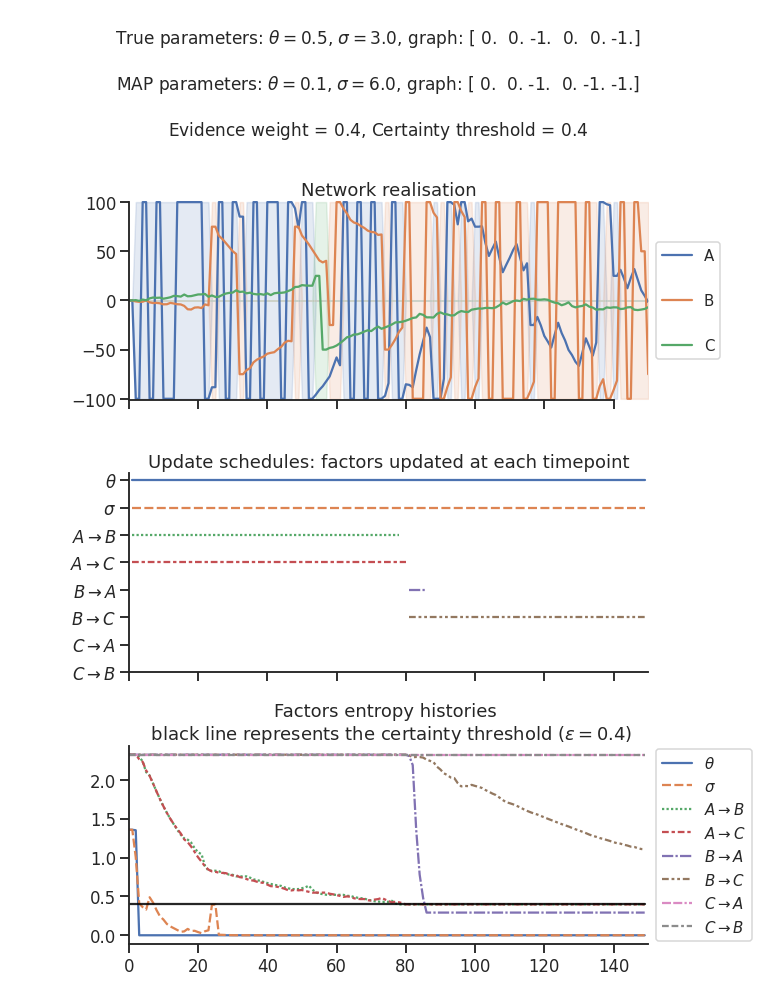

In [9]:
experiment.variational_report(labels=['A', 'B', 'C'])

<AxesSubplot:title={'center':' '}>

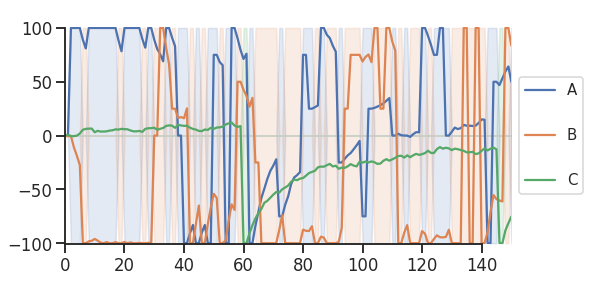

In [9]:
experiment.path_report(title=' ', labels=['A', 'B', 'C'])

In [ ]:
print(internal_states[0].variational_posterior)

non_link_params = internal_states[0].variational_posterior[~internal_states[0]._link_params_bool]

argmax_nonlink = [np.argmax(nl_param) for nl_param in non_link_params]

non_link_names = internal_states[0]._param_names_list[~internal_states[0]._link_params_bool]
internal_states[0]._parameter_set

values_nonlink = [ internal_states[0]._parameter_set[name]['values'][arg] for name, arg in zip(non_link_names, argmax_nonlink)]

values_nonlink


[array([5.84714341e-007, 9.99999415e-001, 7.67271325e-175, 0.00000000e+000])
 array([0.0000000e+000, 0.0000000e+000, 3.8517781e-116, 1.0000000e+000])
 array([9.75037271e-01, 2.45511579e-02, 4.07094054e-04, 4.44518209e-06,
        3.19636504e-08])
 array([4.05789787e-08, 1.42600302e-02, 9.72854909e-01, 1.28849875e-02,
        3.31305177e-08])
 array([9.03018028e-09, 7.28581581e-02, 9.27123226e-01, 1.86069093e-05,
        5.88963698e-16])
 array([1.06706833e-07, 4.47732932e-02, 9.54193732e-01, 1.03286793e-03,
        5.67863212e-11])
 array([9.50357247e-01, 4.96426758e-02, 7.68828997e-08, 3.53029184e-18,
        4.80615469e-33])
 array([4.37858555e-09, 1.20193130e-02, 9.85566596e-01, 2.41408650e-03,
        1.76636399e-10])                                               ]


[0.5, 6.0]

In [ ]:
label_mapping = {
    '0': 'A',
    '1': 'B',
    '2': 'C'
}


def format_ticks(ticks, label_mapping):
    new_ticks = []
    for t in ticks:
        if t[0] not in np.arange(10).astype(str):
            new_ticks.append(f'$\{t}$')
        else:
            split_t = t.split('->')
            nt = f'{label_mapping[split_t[0]]} \\rightarrow {label_mapping[split_t[1]]}'
            new_ticks.append(f'${nt}$')
    return new_ticks

(0.0, 150.0)

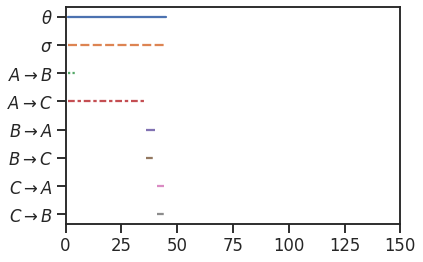

In [ ]:
hist = internal_states[0]._update_schedule_history

hist_idx = (hist*(np.arange(hist.shape[1])[::-1] + 1)).astype(float)

hist_idx[np.where(hist_idx == 0)] = np.nan

df = pd.DataFrame(hist_idx, columns=internal_states[0]._param_names_list[::-1])

ax = sns.lineplot(data=df)
ax.set_yticks(np.arange(df.columns.size) + 1)
ax.set_yticklabels(format_ticks(df.columns, label_mapping))
ax.legend([], frameon=False)
plt.xlim(0, hist.shape[0])

/home/vbtesh/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


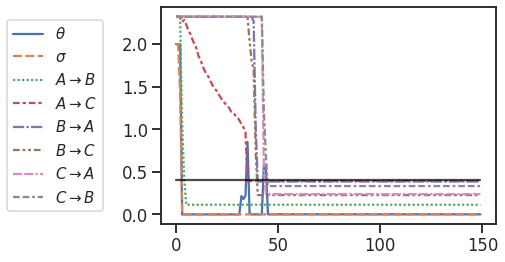

In [ ]:
entropies = internal_states[0].variational_posterior_entropy_history

df = pd.DataFrame(entropies, columns=internal_states[0]._param_names_list)

ax = sns.lineplot(data=df)

sns.lineplot(np.arange(df.shape[0]), internal_states[0]._epsilon*np.ones(df.shape[0]), color='black', alpha=0.7)

ax.legend(format_ticks(df.columns, label_mapping), loc=7, bbox_to_anchor=(-0.15, 0.5), fontsize=15)

In [ ]:
entropies[5, :]

array([2.11553243e-007, 4.24861425e-168, 3.42704687e-001, 3.00392153e-001,
       3.80223068e-001, 3.83174833e-001, 3.85018434e-001, 3.37279564e-001])

In [ ]:
internal_states[0].variational_posterior_

array([array([4.68587176e-005, 9.99953141e-001, 1.47689075e-222, 0.00000000e+000]),
       array([0.00000000e+000, 0.00000000e+000, 1.15918447e-153, 1.00000000e+000]),
       array([9.28281761e-01, 6.77860910e-02, 3.76762531e-03, 1.59390034e-04,
              5.13240548e-06])                                               ,
       array([1.12966137e-06, 4.43932681e-02, 9.44718631e-01, 1.08869033e-02,
              6.79395664e-08])                                               ,
       array([8.83424789e-07, 2.80544340e-02, 9.38835415e-01, 3.31080376e-02,
              1.23036350e-06])                                               ,
       array([8.37659834e-08, 1.22108658e-02, 9.48525873e-01, 3.92623115e-02,
              8.66017175e-07])                                               ,
       array([9.27922568e-01, 7.20287996e-02, 4.86321365e-05, 2.85603322e-10,
              1.45890124e-17])                                               ,
       array([2.64777279e-06, 4.77271891e-02, 9

In [ ]:
internal_states[0]._posterior_params_history[120]

array([array([ -243.23557613,  -240.79358184,  -708.86860453, -7815.91886804]),
       array([-17299.36721157,  -4338.20761401,   -540.38203203,   -212.42713218]),
       array([-19.6768489 , -22.29382718, -25.18373929, -28.34658524,
              -31.78236503])                                         ,
       array([-62.22176487, -54.57334341, -52.40253656, -55.70934432,
              -64.49376668])                                         ,
       array([-1.60943791, -1.60943791, -1.60943791, -1.60943791, -1.60943791]),
       array([-1.60943791, -1.60943791, -1.60943791, -1.60943791, -1.60943791]),
       array([-1.60943791, -1.60943791, -1.60943791, -1.60943791, -1.60943791]),
       array([-1.60943791, -1.60943791, -1.60943791, -1.60943791, -1.60943791])],
      dtype=object)

# Which summary statistics?

For each factor, show its progress towards the certainty threshold
Show the update shedule evolution

True model: [-1.  0.  0.  0. -1.  0.]
Final MAP: [-1.  0.  1.  0. -1. -1.]


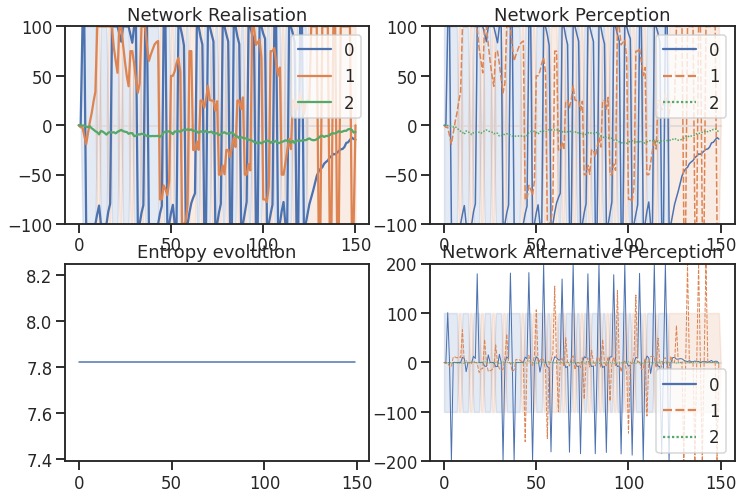

In [ ]:
experiment.entropy_report()

In [ ]:
internal_states[0].variational_posterior

array([array([1.00000000e+00, 4.00221535e-78, 0.00000000e+00, 0.00000000e+00]),
       array([0., 0., 0., 1.]),
       array([1.00000000e+00, 3.96000792e-19, 1.00887360e-39, 1.65356817e-62,
              1.74362104e-87])                                               ,
       array([1.73519485e-07, 1.86272460e-02, 9.57783578e-01, 2.35887245e-02,
              2.78265822e-07])                                               ,
       array([5.01128284e-06, 1.14086819e-03, 4.84436956e-02, 3.83666875e-01,
              5.66743550e-01])                                               ,
       array([0.01226614, 0.18349077, 0.51195974, 0.26642358, 0.02585977]),
       array([0.2, 0.2, 0.2, 0.2, 0.2]), array([0.2, 0.2, 0.2, 0.2, 0.2])],
      dtype=object)

In [ ]:
internal_states[0].variational_posterior_entropy

array([8.46668139e-006, 3.59346216e-105, 3.71612266e-001, 3.65354182e-001,
       3.60886154e-001, 3.87532393e-001, 3.40322380e-001, 3.85316121e-001])

In [ ]:
internal_states[0].update_sche

In [ ]:
internal_states[0]._update_schedule_history

AttributeError: 'MeanField_VIS' object has no attribute '_update_schedule_history'

True model: [1. 0. 0. 1. 0. 0.]
Final MAP: [1. 0. 0. 1. 0. 0.]


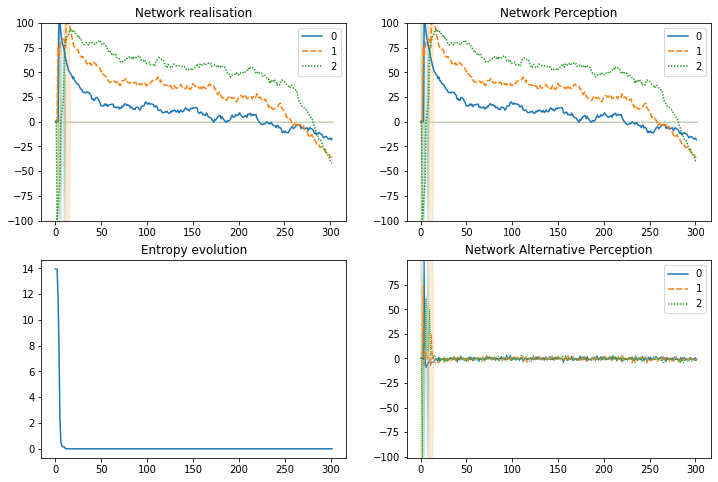

In [ ]:

experiment.entropy_report()

True model: [1. 0. 0. 1. 0. 0.]
Final MAP: [1.  0.5 0.  0.5 0.  0. ]


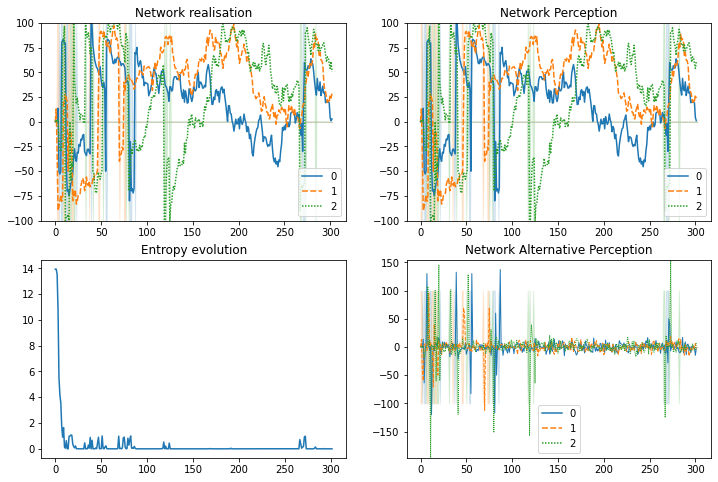

In [ ]:
# Variance = 15, strength = 0.25
experiment.entropy_report()

True model: [1. 0. 0. 1. 0. 0.]
Final MAP: [0.5 0.  0.  0.5 0.  0. ]


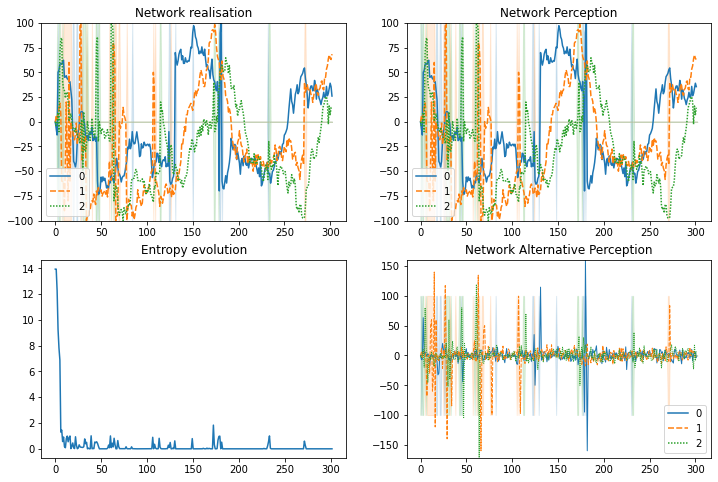

In [ ]:
# Variance = 15, strength = 0.25
experiment.entropy_report()

True model: [1. 0. 0. 1. 0. 0.]
Final MAP: [ 0.   0.  -0.5  0.   0.   0. ]


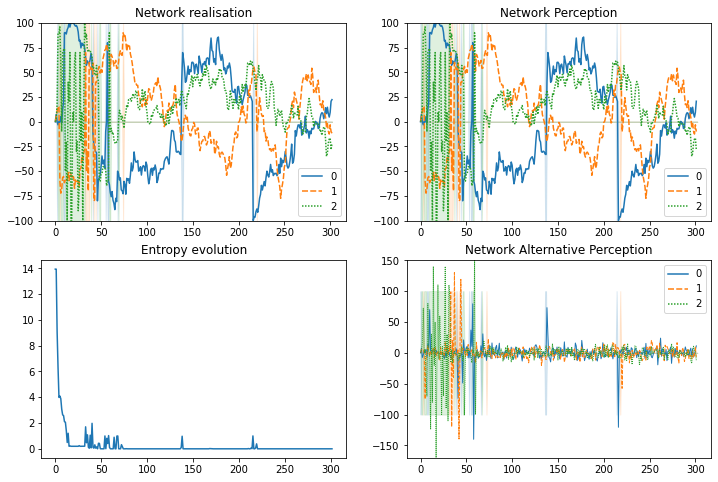

In [ ]:
# Variance = 15, strength = 0.1
experiment.entropy_report()

True model: [1. 0. 0. 1. 0. 0.]
Final MAP: [ 0.5 -0.5  0.   0.5 -0.5  0. ]


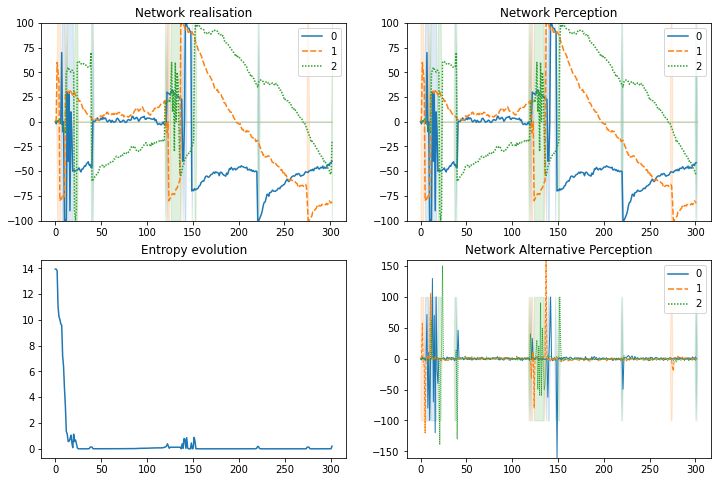

In [ ]:
# Variance = 3, strength = 0.1
experiment.entropy_report()

True model: [1. 0. 0. 1. 0. 0.]
Final MAP: [1. 0. 0. 1. 0. 0.]


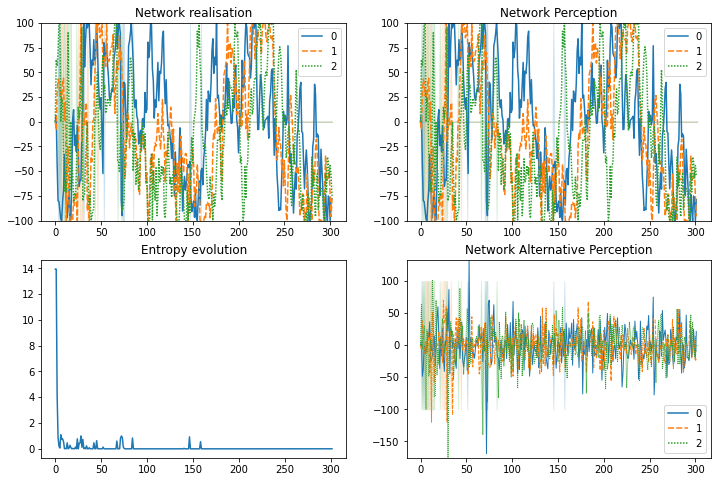

In [ ]:
# Variance = 60, strength = 0.5
experiment.entropy_report()

True model: [1. 0. 0. 1. 0. 0.]
Final MAP: [1. 0. 0. 1. 0. 0.]


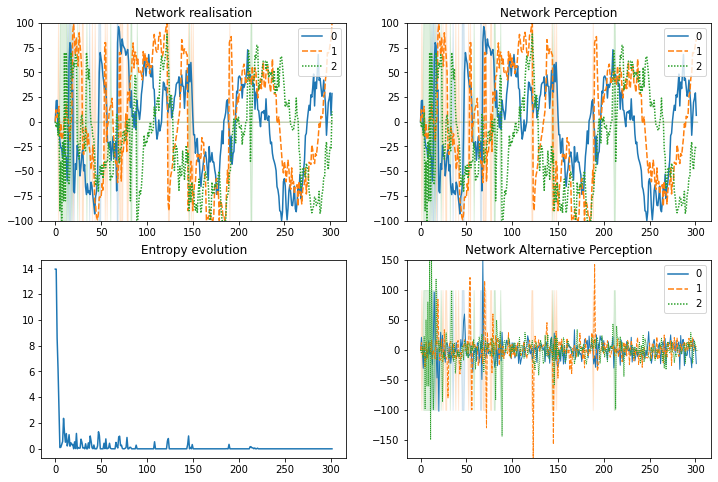

In [ ]:
# Variance = 30, strength = 0.5
experiment.entropy_report()

True model: [1. 0. 0. 1. 0. 0.]
Final MAP: [1. 0. 0. 1. 0. 0.]


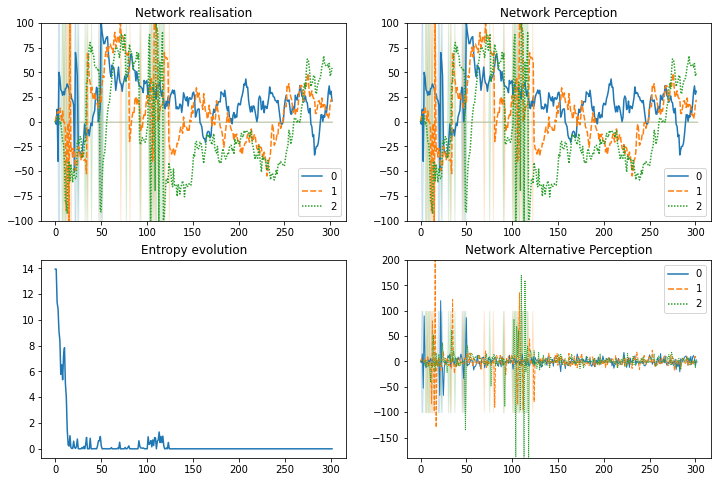

In [ ]:
# Variance = 15, strength = 0.5
experiment.entropy_report()

True model: [1. 0. 0. 1. 0. 0.]
Final MAP: [1. 0. 0. 1. 0. 0.]


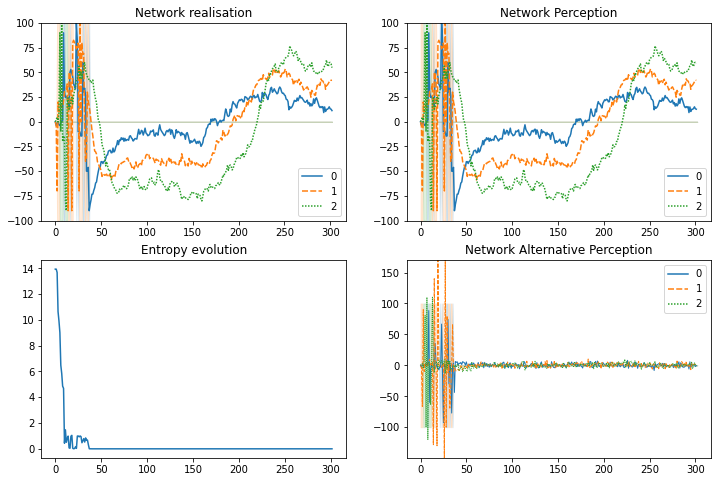

In [ ]:
# Variance = 6, strength = 0.5
experiment.entropy_report()

True model: [1. 0. 0. 1. 0. 0.]
Final MAP: [1. 0. 0. 1. 0. 0.]


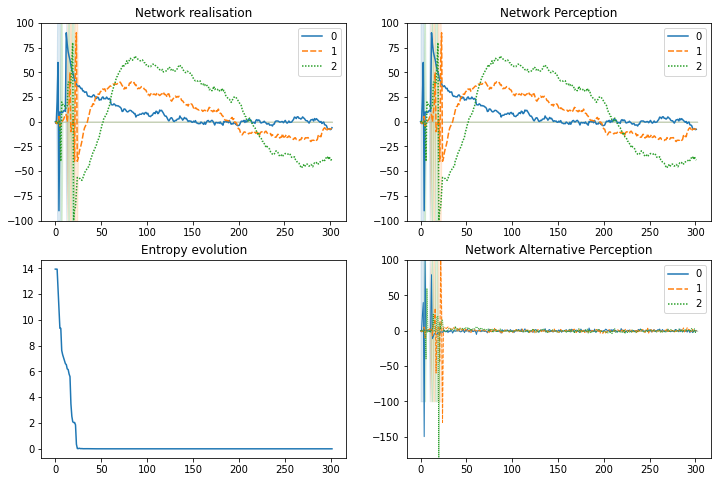

In [ ]:
# Default: variance = 3, strength = 0.5
experiment.entropy_report()

In [ ]:
external_state.data

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.74921954e+00, -1.17698164e+00,  2.15111231e-01],
       [ 2.00000000e+01, -1.93524107e+00,  6.97749004e-01],
       [ 6.00000000e+01,  2.08896405e-01, -1.52562613e+00],
       [-9.00000000e+01,  5.42928703e+00,  3.03146307e-01],
       [ 1.00000000e+01, -4.36419932e+00, -2.14596219e-01],
       [ 9.35931078e+00, -2.46603412e+00, -4.00000000e+01],
       [ 9.62281557e+00, -2.20810945e-01,  2.00000000e+01],
       [ 9.42345849e+00,  1.16696348e+00,  1.79694827e+01],
       [ 1.08998901e+01,  2.12855245e+00,  1.59616261e+01],
       [ 1.15504277e+01,  4.96937684e+00,  1.62718829e+01],
       [ 1.05486127e+01,  4.75568286e+00,  1.36483827e+01],
       [ 9.00000000e+01,  7.27151756e+00,  1.40502468e+01],
       [ 7.87271007e+01,  0.00000000e+00,  1.57540281e+01],
       [ 7.09644659e+01,  9.19030539e+00,  4.00000000e+01],
       [ 6.64632176e+01,  1.81412923e+01,  4.00000000e+01],
       [ 6.27684968e+01,  5.00000000e+01

20
475.4668527268116


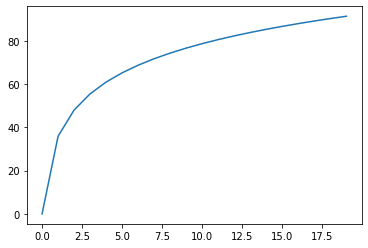

In [ ]:
a = 20 * np.log(np.arange(1, 100, 5))
print(a.size)
print(np.var(a))
plt.plot(a)
plt.show()

20
379.0


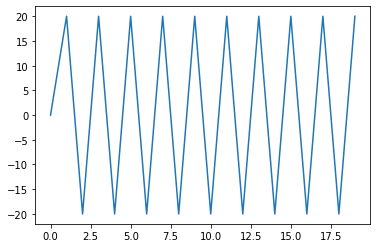

In [ ]:
b = np.array([0, 10, -10, 10, -10, 10, -10, 10, -10, 10, -10, 10, -10, 10, -10, 10, -10, 10, -10, 10]) * 2
print(b.size)
print(np.var(b))
plt.plot(b)

In [ ]:
for i in internal_states[0]._posterior_params_history:
    print(i.min(), i.max())

-9.6566274746046 -9.6566274746046
-9.6566274746046 -9.6566274746046
-9.979363486363152 -9.6566274746046
-20.211126511581202 -9.697010061530179
-67.0283775887786 -11.440931782031475
-192.92318487931755 -11.742994478058074
-195.33097897039315 -11.763956211991896
-215.21070109949986 -12.026265071134317
-216.4475034095692 -13.001453804073506
-218.2888931948423 -14.29288337470096
-222.2258350137835 -15.316127150796637
-224.7853120957309 -17.203326656741595
-231.9886410578174 -18.12508763493557
-270.4373845146157 -20.437033050201098
-369.65520829835367 -21.580837504859858
-487.57357526566466 -23.209645052415713
-516.3268722668262 -23.8291825433493
-596.2767036195282 -24.340726386162498
-656.1076187915015 -25.280167518431416
-735.8807997487879 -25.299258445562202
-837.5679503205988 -25.45390621522701
-864.7099021008735 -26.451671799324647
-915.8725934999957 -29.242663755438233
-1006.0448443558967 -29.832525172667793
-1232.3772322441641 -30.134120952583572
-1237.591315648038 -31.67264740189717

# Fitting

When fitting, we have data about the external states, the interventions a participant made, i.e. action states, and their judgement or any other direct measure of their internal states. 

By definition, sensory states are never observed because they are always implicit. In many cases such as in a control environment, internal states will not be directly observed using judgement but should be inferred from actions states

The dependencies between all core modules imply that fitting a dataset of observations, actions and judgments is only valid for the current global parametrisation of the agent, i.e. the collection of internal, sensory and action states. We can compare how things change when changing one of the modules but we cannot seperate the likelihoods over the different modules.

## Where should the data be stored when fitting?

Basically the question is programming related and asks how should the data be split when initialising the states of the experiment. It could be a seperate method "load_data" called seperately from initialising the agent and the external states. Given the current way the states objects are structured, it creates an inconsistency where parameters have to be specified before hand before being overwritten.

# Questions

## Number of datapoints

The log likelihood is highly sensitive to the number of datapoints. If we assume that the participant cannot observe all datapoints for instance, we artificially reduce the log likelihood. So what can we do?

What do we do when encountering negative infinities, i.e. probability 0. Conceptually it can make sense but it is still highly dependent on the number of datapoints again as some discrete models will simply converge numerically to point masses given enough datapoints. Can we simply conclude to the extreme unlikeliness of this model?

## Number of parameters

Also the number of parameters in a model is not straightforward: in the discrete case model representation has 15625 and links representation has 30, but one is a direct function of the other without adding any additional parameters. In a continuous case, easier to represent as it is the collection of parameters of the PDF.